In [2]:
!pip install category_encoders
from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import category_encoders as ce
from imblearn.over_sampling import SMOTE


In [4]:


# Load the data
data_path = '/content/drive/MyDrive/SEER_en.csv'
data = pd.read_csv(data_path)

# Show basic information and the first few rows of the DataFrame
print(data.info())
print(data.head())

# print(f'Columns:{data.columns}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168148 entries, 0 to 168147
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Patient ID                       168148 non-null  int64  
 1   SYMOGN                           168148 non-null  int64  
 2   Age                              130244 non-null  float64
 3   Gender                           168148 non-null  int64  
 4   SSF1                             168148 non-null  int64  
 5   SSF2                             168148 non-null  int64  
 6   TMRSZ                            168148 non-null  int64  
 7   LYMND                            168148 non-null  int64  
 8   AJCCstage                        168148 non-null  int64  
 9   Combined Summary Stage (2004+)   168148 non-null  object 
 10  RT                               168148 non-null  int64  
 11  ST                               168148 non-null  int64  
 12  RX

In [5]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/SEER_en.csv')

# Impute missing values for 'Age'
imputer = SimpleImputer(strategy='median')
data['Age'] = imputer.fit_transform(data[['Age']])

# Define columns that need encoding
categorical_features = ['SYMOGN', 'Gender', 'SSF1', 'SSF2', 'LYMND', 'AJCCstage', 'RT', 'ST', 'RX Summ--Surg Prim Site (1998+)']
numeric_features = ['TMRSZ', 'Age', 'Income', 'Residence', 'Year of diagnosis']

# Prepare target and features
X = data.drop(columns=['Target', 'Patient ID', 'Race', 'Race and Origin', 'Combined Summary Stage (2004+)', 'Sequence number'])
y = data['Target']

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)
# Impute missing values
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Split the data into training (60%) and testing (40%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Further split the training data into training (75% of 80%) and validation (25% of 80%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Apply target encoding
target_encoder = ce.TargetEncoder(cols=categorical_features)
X_train[categorical_features] = target_encoder.fit_transform(X_train[categorical_features], y_train)
X_val[categorical_features] = target_encoder.transform(X_val[categorical_features])
X_test[categorical_features] = target_encoder.transform(X_test[categorical_features])

# Setup the preprocessing for numeric columns
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])



# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Convert the processed data into PyTorch tensors
X_train_torch = torch.tensor(X_train_res.astype(np.float32))
y_train_torch = torch.tensor(y_train_res.values.astype(np.float32)).view(-1, 1)
X_val_torch = torch.tensor(X_val.astype(np.float32))
y_val_torch = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
X_test_torch = torch.tensor(X_test.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Data loaders
train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=64, shuffle=False)



In [6]:
# Define a more complex model class
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

In [9]:
# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

# Calculate class weights based on the training data
def calculate_class_weights(train_loader):
    class_counts = torch.zeros(2)
    for inputs, labels in train_loader:
        class_counts[0] += (labels == 0).sum().item()
        class_counts[1] += (labels == 1).sum().item()
    total_samples = class_counts.sum().item()
    class_weights = total_samples / (class_counts * 2.0)
    return class_weights

class_weights = calculate_class_weights(train_loader)


# Initialize the loss function with the computed class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.RMSprop(model.parameters(), lr=0.00001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

best_test_loss = float('inf')
best_test_accuracy = 0

# Accuracy calculation function
def calculate_accuracy(outputs, labels):
    preds = torch.round(torch.sigmoid(outputs))
    correct = (preds == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

#metrics calculation function
def calculate_metrics(outputs, labels):
    preds = torch.round(torch.sigmoid(outputs))
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    outputs = outputs.cpu().numpy()
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auroc = roc_auc_score(labels, outputs)
    precision_recall, recall, _ = precision_recall_curve(labels, outputs)
    prc_auc = auc(recall, precision_recall)
    return precision, recall, f1, auroc, prc_auc

#fix seed function
def fix_seed(seed):
    print(f"Random seed: {seed}\n")
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(42)

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=20):
    global best_test_loss, best_test_accuracy
    for epoch in range(num_epochs):
        model.train()  # Training phase
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            accuracy = calculate_accuracy(outputs, labels)
            total_accuracy += accuracy.item()

        average_train_loss = total_loss / len(train_loader)
        average_train_accuracy = total_accuracy / len(train_loader)

        model.eval()  # Evaluation phase
        total_val_loss = 0
        total_val_accuracy = 0
        all_val_labels = []
        all_val_outputs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                accuracy = calculate_accuracy(outputs, labels)
                total_val_accuracy += accuracy.item()

                all_val_labels.append(labels)
                all_val_outputs.append(outputs)

        average_val_loss = total_val_loss / len(val_loader)
        average_val_accuracy = total_val_accuracy / len(val_loader)
        scheduler.step(average_val_loss)

        all_val_labels = torch.cat(all_val_labels)
        all_val_outputs = torch.cat(all_val_outputs)
        precision, recall, f1, auroc, prc_auc = calculate_metrics(all_val_outputs, all_val_labels)

        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {average_val_accuracy:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, AUROC: {auroc:.4f}')

        # Checkpointing
        if average_val_loss < best_test_loss:
            best_test_loss = average_val_loss
            best_test_accuracy = average_val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

Random seed: 42



In [10]:
def fix_seed(seed):
    print(f"Random seed: {seed}\n")
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(42)

# Main simulation loop
num_simulations = 30
num_epochs = 10

for simulation in range(num_simulations):
    print(f'Simulation {simulation + 1}/{num_simulations}')

    # Split data into training and testing sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=simulation)

    # Further split the training data into training (75% of 80%) and validation (25% of 80%) sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=simulation)

    # Apply preprocessing
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Convert to PyTorch tensors
    X_train_res = torch.tensor(X_train_res.astype(np.float32))
    X_val = torch.tensor(X_val.astype(np.float32))
    X_test = torch.tensor(X_test.astype(np.float32))
    y_train_res = torch.tensor(y_train_res.values.astype(np.float32)).unsqueeze(1)
    y_val = torch.tensor(y_val.values.astype(np.float32)).unsqueeze(1)
    y_test = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_res, y_train_res)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)




    class_weights = calculate_class_weights(train_loader)

    # Initialize model
    model = SimpleNN(input_dim=X_train_res.shape[1])
    model.apply(initialize_weights)

    # Initialize criterion, optimizer, and scheduler
    criterion1 = nn.BCEWithLogitsLoss()
    optimizer1 = optim.RMSprop(model.parameters(), lr=1e-6)
    scheduler1 = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    # Train and evaluate the model
    train_and_evaluate(model, train_loader, val_loader, test_loader, criterion1, optimizer1, scheduler1, num_epochs=num_epochs)



Random seed: 42

Simulation 1/30
Epoch 1/10, AUROC: 0.7208
Epoch 2/10, AUROC: 0.7277
Epoch 3/10, AUROC: 0.7289
Epoch 4/10, AUROC: 0.7300
Epoch 5/10, AUROC: 0.7304
Epoch 6/10, AUROC: 0.7309
Epoch 7/10, AUROC: 0.7312
Epoch 8/10, AUROC: 0.7316
Epoch 9/10, AUROC: 0.7318
Epoch 10/10, AUROC: 0.7320
Simulation 2/30
Epoch 1/10, AUROC: 0.6942
Epoch 2/10, AUROC: 0.7042
Epoch 3/10, AUROC: 0.7099
Epoch 4/10, AUROC: 0.7115
Epoch 5/10, AUROC: 0.7128
Epoch 6/10, AUROC: 0.7136
Epoch 7/10, AUROC: 0.7143
Epoch 8/10, AUROC: 0.7150
Epoch 9/10, AUROC: 0.7155
Epoch 10/10, AUROC: 0.7160
Simulation 3/30
Epoch 1/10, AUROC: 0.6930
Epoch 2/10, AUROC: 0.7104
Epoch 3/10, AUROC: 0.7143
Epoch 4/10, AUROC: 0.7196
Epoch 5/10, AUROC: 0.7244
Epoch 6/10, AUROC: 0.7266
Epoch 7/10, AUROC: 0.7279
Epoch 8/10, AUROC: 0.7286
Epoch 9/10, AUROC: 0.7288
Epoch 10/10, AUROC: 0.7291
Simulation 4/30
Epoch 1/10, AUROC: 0.6671
Epoch 2/10, AUROC: 0.6837
Epoch 3/10, AUROC: 0.6988
Epoch 4/10, AUROC: 0.7072
Epoch 5/10, AUROC: 0.7106
Epoch 

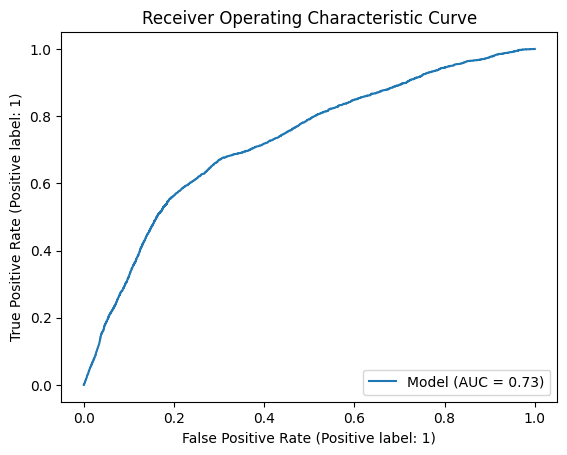

AUROC: 0.7261


In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

def evaluate_model_roc(model, data_loader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            y_scores.extend(outputs.squeeze().tolist())  # Get the model scores
            y_true.extend(labels.tolist())

    return y_true, y_scores

# Call the evaluation function for the last model to plot the ROC curve
y_true, y_scores = evaluate_model_roc(model, test_loader)

# Plot the ROC curve using RocCurveDisplay.from_predictions
display = RocCurveDisplay.from_predictions(y_true, y_scores, name="Model")
_ = display.ax_.set_title("Receiver Operating Characteristic Curve")

plt.show()

# Calculate the area under the curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print(f'AUROC: {roc_auc:.4f}')
